<a href="https://colab.research.google.com/github/hassiahk/Double-Hard-Debias/blob/main/notebooks/Normalized_Unnormalized_GloVe_Evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import codecs
import os
import json
import operator
import random
import numpy as np
import scipy.spatial
import warnings

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything()

In [ ]:
from double_hard_debias.utils import load_glove_txt


glove, glove_word2idx, vocab = load_glove_txt("../data/vectors.txt")

322636 (322636, 300) 322636


In [ ]:
dhd_glove_reproduced, dhd_glove_word2idx_reproduced, dhd_vocab_reproduced = load_glove_txt("../data/glove_dhd.txt")

322636 (322636, 300) 322636


### Restrict the vocabulary

In [ ]:
from tqdm import tqdm
from double_hard_debias.utils import limit_vocab


gender_specific = []

with open('./data/male_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())
with open('./data/female_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())
print(len(gender_specific))

with codecs.open('./data/gender_specific_full.json') as f:
    gender_specific.extend(json.load(f))

print(len(gender_specific))

442
1883


In [ ]:
glove_limit, glove_word2idx_limit, glove_vocab_limit = limit_vocab(
    glove, glove_word2idx, vocab, exclude=gender_specific
)
dhd_limit, dhd_word2idx_limit, dhd_vocab_limit = limit_vocab(
    dhd_glove_reproduced, dhd_glove_word2idx_reproduced, dhd_vocab_reproduced, exclude=gender_specific
)

  0%|          | 0/50000 [00:00<?, ?it/s]

size of vocabulary: 47628


100%|██████████| 50000/50000 [00:00<00:00, 397417.45it/s]


size of vocabulary: 47628


In [ ]:
from double_hard_debias.utils import compute_bias_by_projection


he_embed = glove[glove_word2idx['he'], :]
she_embed = glove[glove_word2idx['she'], :]

gender_bias_before = compute_bias_by_projection(
    glove_limit, glove_word2idx_limit, glove_vocab_limit, he_embed, she_embed
)
sorted_g = sorted(gender_bias_before.items(), key=operator.itemgetter(1))

In [ ]:
def visualize(vectors, y_true, y_pred, ax, title, random_state):
    
    # perform TSNE
    vectors = normalize(vectors)
    X_embedded = TSNE(n_components=2, random_state=random_state).fit_transform(vectors)
    for x,p,y in zip(X_embedded, y_pred, y_true):
        if y:
            ax.scatter(x[0], x[1], marker = '.', c = 'c')
        else:
            ax.scatter(x[0], x[1], marker = 'x', c = 'darkviolet')
    
    return ax

def cluster_and_visualize(words, X1, title, random_state, tsne_random_state, y_true, num=2):
    
    kmeans_1 = KMeans(n_clusters=num, random_state=random_state).fit(X1)
    y_pred_1 = kmeans_1.predict(X1)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_1) ]
    print('precision', max(sum(correct)/float(len(correct)), 1 - sum(correct)/float(len(correct))))
    
    fig, axs = plt.subplots(1, 1, figsize=(6, 3))
    ax1 = visualize(X1, y_true, y_pred_1, axs, title, tsne_random_state)
    plt.title(title)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from double_hard_debias.utils import remove_vector_component
import matplotlib.pyplot as plt
from cycler import cycler
%matplotlib inline

size = 500
female = [item[0] for item in sorted_g[:size]]
male = [item[0] for item in sorted_g[-size:]]
y_true = [1]*size + [0]*size

In [ ]:
random_state = 0
tsne_random_state = 5

precision 1.0


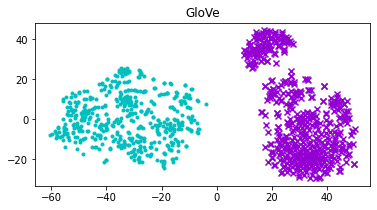

In [ ]:
cluster_and_visualize(male + female, remove_vector_component(male + female, glove_limit, glove_word2idx_limit), 
                          'GloVe', random_state, tsne_random_state, y_true)

precision 0.741


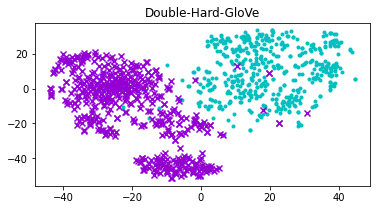

In [ ]:
cluster_and_visualize(male + female, remove_vector_component(male + female, dhd_limit, dhd_word2idx_limit), 
                          'Double-Hard-GloVe', random_state, tsne_random_state, y_true)

In [ ]:
def cluster(words, X1, random_state, y_true, num=2):
    
    kmeans_1 = KMeans(n_clusters=num, random_state=random_state).fit(X1)
    y_pred_1 = kmeans_1.predict(X1)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_1) ]
    print('precision', max(sum(correct)/float(len(correct)), 1 - sum(correct)/float(len(correct))))

def my_cluster(wv, word2idx, start=0, size=500, random_state = 1):
    
    if start == 0:
        female = [item[0] for item in sorted_g[:size]]
        male = [item[0] for item in sorted_g[-size:]]
    else:
        female = [item[0] for item in sorted_g[start:size+start]]
        male = [item[0] for item in sorted_g[-(start+size):-start]]

    y_true = [1]*size + [0]*size
    
    cluster(male + female, remove_vector_component(male + female, wv, word2idx), random_state, y_true)

In [ ]:
random_state_ = 0
start = 0
end = 100

my_cluster(dhd_limit, dhd_word2idx_limit, start, end, random_state=random_state_)

precision 0.665


In [ ]:
random_state_ = 0
start = 0
end = 500

my_cluster(dhd_limit, dhd_word2idx_limit, start, end, random_state=random_state_)

precision 0.741


In [ ]:
random_state_ = 0
start = 0
end = 1000

my_cluster(dhd_limit, dhd_word2idx_limit, start, end, random_state=random_state_)

precision 0.704


### Normalize the embeddings

In [ ]:
dhd_glove_normalized = normalize(dhd_glove_reproduced)
glove_normalized = normalize(glove)

In [ ]:
glove_limit, glove_word2idx_limit, glove_vocab_limit = limit_vocab(
    glove_normalized, glove_word2idx, vocab, exclude=gender_specific
)
dhd_limit, dhd_word2idx_limit, dhd_vocab_limit = limit_vocab(
    dhd_glove_normalized, dhd_glove_word2idx_reproduced, dhd_vocab_reproduced, exclude=gender_specific
)

100%|██████████| 50000/50000 [00:00<00:00, 400326.04it/s]


size of vocabulary: 47628


100%|██████████| 50000/50000 [00:00<00:00, 413282.41it/s]


size of vocabulary: 47628


In [ ]:
from double_hard_debias.utils import compute_bias_by_projection


he_embed = glove[glove_word2idx['he'], :]
she_embed = glove[glove_word2idx['she'], :]

gender_bias_before = compute_bias_by_projection(
    glove_limit, glove_word2idx_limit, glove_vocab_limit, he_embed, she_embed
)
sorted_g = sorted(gender_bias_before.items(), key=operator.itemgetter(1))

In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from double_hard_debias.utils import remove_vector_component
import matplotlib.pyplot as plt
from cycler import cycler
%matplotlib inline

size = 500
female = [item[0] for item in sorted_g[:size]]
male = [item[0] for item in sorted_g[-size:]]
y_true = [1]*size + [0]*size

In [ ]:
random_state = 0
tsne_random_state = 5

precision 1.0


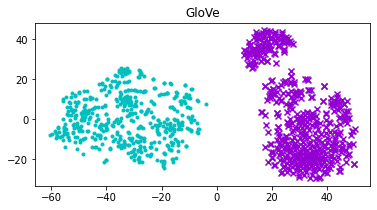

In [ ]:
cluster_and_visualize(male + female, remove_vector_component(male + female, glove_limit, glove_word2idx_limit), 
                          'GloVe', random_state, tsne_random_state, y_true)

precision 0.835


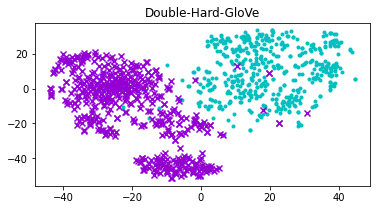

In [ ]:
cluster_and_visualize(male + female, remove_vector_component(male + female, dhd_limit, dhd_word2idx_limit), 
                          'Double-Hard-GloVe', random_state, tsne_random_state, y_true)

In [ ]:
random_state_ = 0
start = 0
end = 100

my_cluster(dhd_limit, dhd_word2idx_limit, start, end, random_state=random_state_)

precision 0.68


In [ ]:
random_state_ = 0
start = 0
end = 500

my_cluster(dhd_limit, dhd_word2idx_limit, start, end, random_state=random_state_)

precision 0.835


In [ ]:
random_state_ = 0
start = 0
end = 1000

my_cluster(dhd_limit, dhd_word2idx_limit, start, end, random_state=random_state_)

precision 0.6435


### Include whole vocabulary

In [ ]:
import string
from typing import Dict, List, Optional, Tuple
from double_hard_debias.utils import has_punctuation, has_digit


def limit_vocab(
    word_vec: np.ndarray,
    word2idx: Dict[str, int],
    vocab: List[str],
    exclude: Optional[List[str]] = None,
) -> Tuple[np.ndarray, Dict[str, int], List[str]]:
    """
    Limits the vocabulary by removing the words given in `exclude`.
    """
    vocab_limited = []

    for word in tqdm(vocab):
        if word.lower() != word:
            continue
        if len(word) >= 20:
            continue
        if has_digit(word):
            continue
        if "_" in word:
            punctuations = [has_punctuation(sub_word) for sub_word in word.split("_")]
            if not any(punctuations):
                vocab_limited.append(word)
            continue
        if has_punctuation(word):
            continue
        vocab_limited.append(word)

    if exclude:
        vocab_limited = list(set(vocab_limited) - set(exclude))

    print(f"Vocabulary size: {len(vocab_limited)}")

    word_vec_limited = np.zeros((len(vocab_limited), len(word_vec[0, :])))
    for i, word in enumerate(vocab_limited):
        word_vec_limited[i, :] = word_vec[word2idx[word], :]

    word2idx_limited = {word: i for i, word in enumerate(vocab_limited)}

    return word_vec_limited, word2idx_limited, vocab_limited

In [ ]:
glove_limit, glove_word2idx_limit, glove_vocab_limit = limit_vocab(
    glove, glove_word2idx, vocab, exclude=gender_specific
)
dhd_limit, dhd_word2idx_limit, dhd_vocab_limit = limit_vocab(
    dhd_glove_reproduced, dhd_glove_word2idx_reproduced, dhd_vocab_reproduced, exclude=gender_specific
)

100%|██████████| 322636/322636 [00:00<00:00, 382227.88it/s]


size of vocabulary: 314326


100%|██████████| 322636/322636 [00:00<00:00, 395009.51it/s]


size of vocabulary: 314326


In [ ]:
from double_hard_debias.utils import compute_bias_by_projection


he_embed = glove[glove_word2idx['he'], :]
she_embed = glove[glove_word2idx['she'], :]

gender_bias_before = compute_bias_by_projection(
    glove_limit, glove_word2idx_limit, glove_vocab_limit, he_embed, she_embed
)
sorted_g = sorted(gender_bias_before.items(), key=operator.itemgetter(1))

In [ ]:
def visualize(vectors, y_true, y_pred, ax, title, random_state):
    
    # perform TSNE
    vectors = normalize(vectors)
    X_embedded = TSNE(n_components=2, random_state=random_state).fit_transform(vectors)
    for x,p,y in zip(X_embedded, y_pred, y_true):
        if y:
            ax.scatter(x[0], x[1], marker = '.', c = 'c')
        else:
            ax.scatter(x[0], x[1], marker = 'x', c = 'darkviolet')
    
    return ax

def cluster_and_visualize(words, X1, title, random_state, tsne_random_state, y_true, num=2):
    
    kmeans_1 = KMeans(n_clusters=num, random_state=random_state).fit(X1)
    y_pred_1 = kmeans_1.predict(X1)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_1) ]
    print('precision', max(sum(correct)/float(len(correct)), 1 - sum(correct)/float(len(correct))))
    
    fig, axs = plt.subplots(1, 1, figsize=(6, 3))
    ax1 = visualize(X1, y_true, y_pred_1, axs, title, tsne_random_state)
    plt.title(title)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from double_hard_debias.utils import remove_vector_component
import matplotlib.pyplot as plt
from cycler import cycler
%matplotlib inline

size = 500
female = [item[0] for item in sorted_g[:size]]
male = [item[0] for item in sorted_g[-size:]]
y_true = [1]*size + [0]*size

In [ ]:
random_state = 0
tsne_random_state = 5

precision 1.0


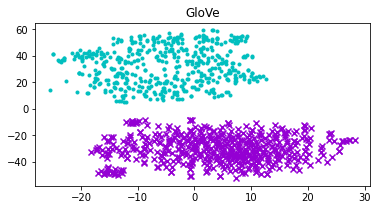

In [ ]:
cluster_and_visualize(male + female, remove_vector_component(male + female, glove_limit, glove_word2idx_limit), 
                          'GloVe', random_state, tsne_random_state, y_true)

precision 0.777


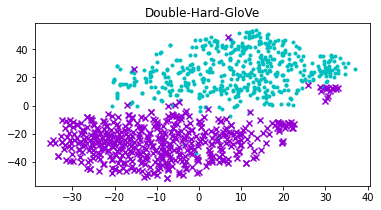

In [ ]:
cluster_and_visualize(male + female, remove_vector_component(male + female, dhd_limit, dhd_word2idx_limit), 
                          'Double-Hard-GloVe', random_state, tsne_random_state, y_true)

In [ ]:
def cluster(words, X1, random_state, y_true, num=2):
    
    kmeans_1 = KMeans(n_clusters=num, random_state=random_state).fit(X1)
    y_pred_1 = kmeans_1.predict(X1)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_1) ]
    print('precision', max(sum(correct)/float(len(correct)), 1 - sum(correct)/float(len(correct))))

def my_cluster(wv, word2idx, start=0, size=500, random_state = 1):
    
    if start == 0:
        female = [item[0] for item in sorted_g[:size]]
        male = [item[0] for item in sorted_g[-size:]]
    else:
        female = [item[0] for item in sorted_g[start:size+start]]
        male = [item[0] for item in sorted_g[-(start+size):-start]]

    y_true = [1]*size + [0]*size
    
    cluster(male + female, remove_vector_component(male + female, wv, word2idx), random_state, y_true)

In [ ]:
random_state_ = 0
start = 0
end = 100

my_cluster(dhd_limit, dhd_word2idx_limit, start, end, random_state=random_state_)

precision 0.875


In [ ]:
random_state_ =0
start = 0
end = 500

my_cluster(dhd_limit, dhd_word2idx_limit, start, end, random_state=random_state_)

precision 0.777


In [ ]:
random_state_ = 0
start = 0
end = 1000

my_cluster(dhd_limit, dhd_word2idx_limit, start, end, random_state=random_state_)

precision 0.783


### Normalize the embeddings

In [ ]:
dhd_glove_normalized = normalize(dhd_glove_reproduced)
glove_normalized = normalize(glove)

In [ ]:
glove_limit, glove_word2idx_limit, glove_vocab_limit = limit_vocab(
    glove_normalized, glove_word2idx, vocab, exclude=gender_specific
)
dhd_limit, dhd_word2idx_limit, dhd_vocab_limit = limit_vocab(
    dhd_glove_normalized, dhd_glove_word2idx_reproduced, dhd_vocab_reproduced, exclude=gender_specific
)

100%|██████████| 322636/322636 [00:00<00:00, 403204.30it/s]


size of vocabulary: 314326


100%|██████████| 322636/322636 [00:00<00:00, 394085.79it/s]


size of vocabulary: 314326


In [ ]:
from double_hard_debias.utils import compute_bias_by_projection


he_embed = glove_normalized[glove_word2idx['he'], :]
she_embed = glove_normalized[glove_word2idx['she'], :]

gender_bias_before = compute_bias_by_projection(
    glove_limit, glove_word2idx_limit, glove_vocab_limit, he_embed, she_embed
)
sorted_g = sorted(gender_bias_before.items(), key=operator.itemgetter(1))

In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from double_hard_debias.utils import remove_vector_component
import matplotlib.pyplot as plt
from cycler import cycler
%matplotlib inline

size = 500
female = [item[0] for item in sorted_g[:size]]
male = [item[0] for item in sorted_g[-size:]]
y_true = [1]*size + [0]*size

In [ ]:
random_state = 0
tsne_random_state = 5

precision 0.999


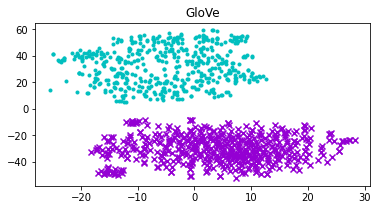

In [ ]:
cluster_and_visualize(male + female, remove_vector_component(male + female, glove_limit, glove_word2idx_limit), 
                          'GloVe', random_state, tsne_random_state, y_true)

precision 0.921


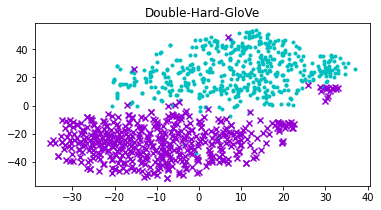

In [ ]:
cluster_and_visualize(male + female, remove_vector_component(male + female, dhd_limit, dhd_word2idx_limit), 
                          'Double-Hard-GloVe', random_state, tsne_random_state, y_true)

In [ ]:
random_state_ = 0
start = 0
end = 100

my_cluster(dhd_limit, dhd_word2idx_limit, start, end, random_state=random_state_)

precision 0.99


In [ ]:
random_state_ = 0
start = 0
end = 500

my_cluster(dhd_limit, dhd_word2idx_limit, start, end, random_state=random_state_)

precision 0.921


In [ ]:
random_state_ = 0
start = 0
end = 1000

my_cluster(dhd_limit, dhd_word2idx_limit, start, end, random_state=random_state_)

precision 0.905
